In [111]:
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import stats

In [112]:
# Read the sales data
df = pd.read_csv("resources/store_data.csv")
# Display sample data
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Unit Price,Price without discount,Unit Cost
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0%,41.9136,130.9800,130.98,20.9568
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0%,219.5820,243.9800,243.98,73.1940
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0%,6.8714,7.3100,7.31,3.4357
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,45%,-383.0310,191.5155,348.21,80.0883
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,20%,2.5164,11.1840,13.98,4.0542


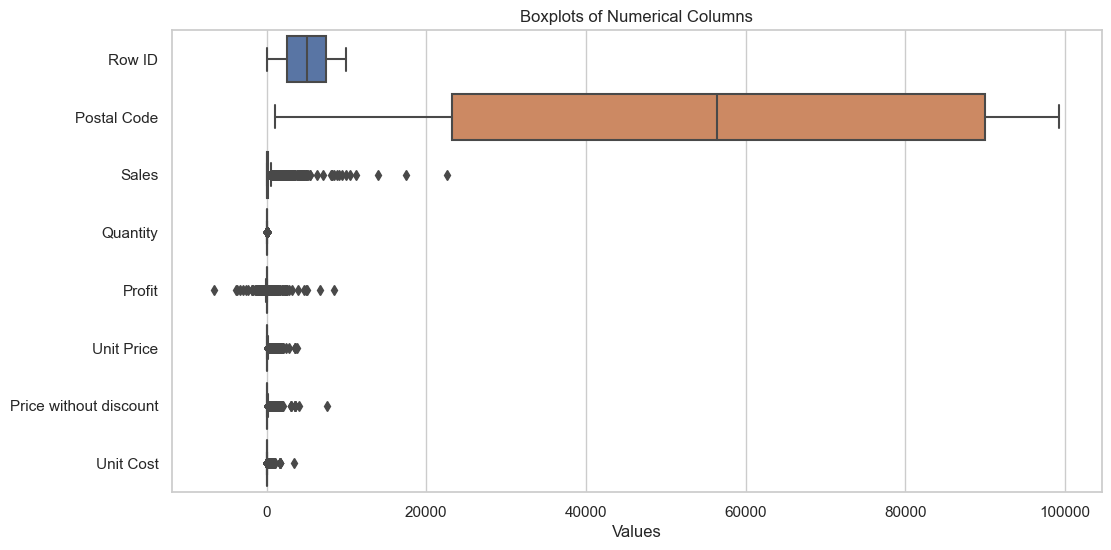

In [113]:
#Boxplot of DataFrame
numerical_columns = df.select_dtypes(include=['float64', 'int64'])

# Set the style for the plots 
sns.set(style="whitegrid")

# Create boxplots for all numerical columns
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.boxplot(data=numerical_columns, orient="h")  # "orient" specifies horizontal orientation

# Add labels and title
plt.xlabel('Values')
plt.title('Boxplots of Numerical Columns')

# Show the plot
plt.show()

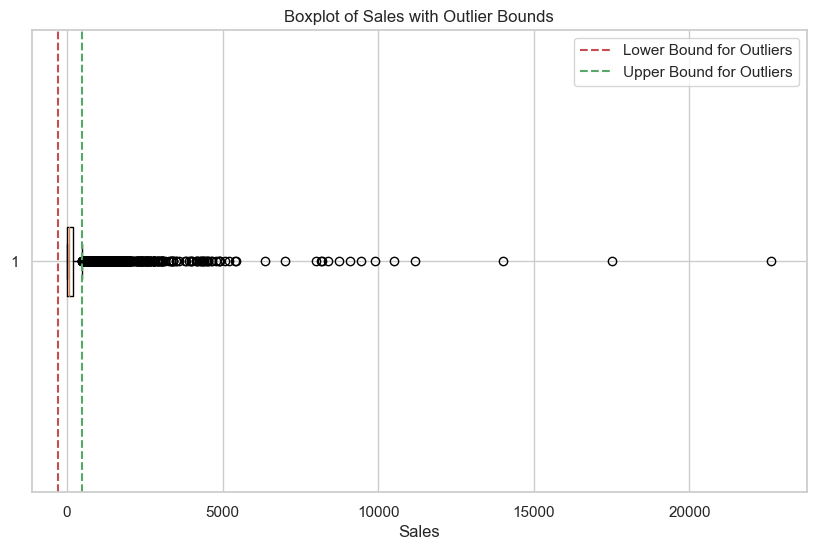

498.93


In [114]:
# Boxplot of Sales
data = df['Sales']

# Create a boxplot with a larger figure size
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Create the boxplot
plt.boxplot(data, vert=False)  # Set vert to False for a horizontal boxplot

# Calculate the IQR for 'Sales'
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Add vertical lines to indicate the lower and upper bounds for outliers
plt.axvline(lower_bound, color='r', linestyle='--', label='Lower Bound for Outliers')
plt.axvline(upper_bound, color='g', linestyle='--', label='Upper Bound for Outliers')

# Add labels and title
plt.xlabel('Sales')
plt.title('Boxplot of Sales with Outlier Bounds')

# Add a legend to explain the vertical lines
plt.legend()

# Show the plot
plt.show()
print(upper_bound)


In [115]:
#drop the outliers for sales
df.drop(index= df[(df['Sales'] > 499)].index, inplace=True)

In [116]:
# Determine the number of unique values in each column.
df.nunique()

Row ID                    8827
Order ID                  4725
Order Date                1224
Ship Date                 1316
Ship Mode                    4
Customer ID                790
Customer Name              790
Segment                      3
Country                      1
City                       527
State                       48
Postal Code                626
Region                       4
Product ID                1769
Category                     3
Sub-Category                17
Product Name              1754
Sales                     4882
Quantity                    14
Discount                    12
Profit                    6309
Unit Price                2333
Price without discount    1020
Unit Cost                 1469
dtype: int64

In [117]:
#change order date and ship date into datetime 
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8827 entries, 0 to 9993
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Row ID                  8827 non-null   int64         
 1   Order ID                8827 non-null   object        
 2   Order Date              8827 non-null   datetime64[ns]
 3   Ship Date               8827 non-null   datetime64[ns]
 4   Ship Mode               8827 non-null   object        
 5   Customer ID             8827 non-null   object        
 6   Customer Name           8827 non-null   object        
 7   Segment                 8827 non-null   object        
 8   Country                 8827 non-null   object        
 9   City                    8827 non-null   object        
 10  State                   8827 non-null   object        
 11  Postal Code             8827 non-null   int64         
 12  Region                  8827 non-null   object  

In [118]:
# Split the monthly sales by date
sales_data = df[['Order Date', 'Sales']].copy()

# Extract year and month
sales_data['Year'] = sales_data['Order Date'].dt.year
sales_data['Month'] = sales_data['Order Date'].dt.month

# Group by year and month and sum the sales
sales_data = sales_data.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Create the 'Date' column with the last day of the month
sales_data['Date'] = pd.to_datetime(sales_data[['Year', 'Month']].assign(day=1)) + pd.DateOffset(months=1) - pd.DateOffset(days=1)

# Create the 'sales_df' DataFrame
sales_df = sales_data[['Date', 'Sales', 'Month', 'Year']]

# Display the first few rows of the resulting DataFrame
sales_df.head()

,Date,Sales,Month,Year
0,2014-01-31,5438.155,1,2014
1,2014-02-28,3263.672,2,2014
2,2014-03-31,12452.536,3,2014
3,2014-04-30,11421.191,4,2014
4,2014-05-31,10456.715,5,2014


In [119]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    48 non-null     datetime64[ns]
 1   Sales   48 non-null     float64       
 2   Month   48 non-null     int64         
 3   Year    48 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.6 KB


In [120]:
#Preprocess the data
sales_df.sort_values('Date')[:5]



,Date,Sales,Month,Year
0,2014-01-31,5438.155,1,2014
1,2014-02-28,3263.672,2,2014
2,2014-03-31,12452.536,3,2014
3,2014-04-30,11421.191,4,2014
4,2014-05-31,10456.715,5,2014


In [121]:
X = sales_df[['Year', 'Month']]  # Features
y = sales_df['Sales']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [122]:
# Calculate MSE and R-squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Squared Error: 12739756.681948546
Root Mean Squared Error: 3569.279574640875
R-squared: 0.2851745963109831


In [123]:
coefficients = model.coef_
print("Coefficients:", coefficients)

Coefficients: [3493.71840674 1789.91143265]


R-squared (R2) for Actual Sales in 2014: 1.0
R-squared (R2) for Predicted Sales in 2014: 0.7216170531446237


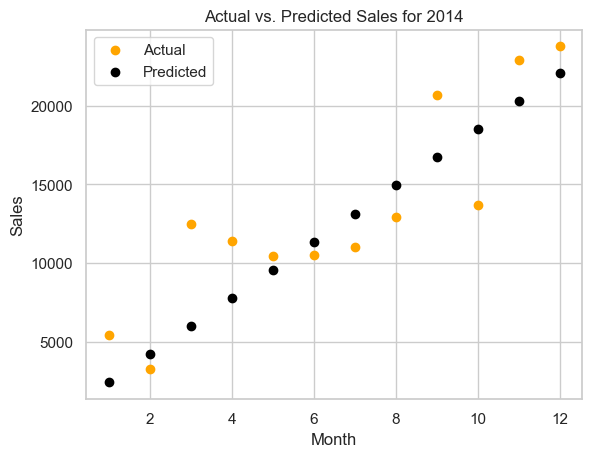

In [124]:
#Graph Sales Data by Year

# Features used during model training
features_used_during_training = ['Year', 'Month']

# Filter the data for the year 2014
sales_df_2014 = sales_df[sales_df['Year'] == 2014]

# Extract features (Year and Month) for the year 2014
X_2014 = sales_df_2014[features_used_during_training]

# Predict the sales for 2014 using the model
y_pred_2014 = model.predict(X_2014)

# Actual sales for 2014 (assuming you have this data)
y_2014 = sales_df_2014['Sales']

# Calculate R2 for actual and predicted sales in 2014
r2_actual_2014 = r2_score(y_2014, y_2014)  # R2 for actual sales in 2014
r2_predicted_2014 = r2_score(y_2014, y_pred_2014)  # R2 for predicted sales in 2014

print("R-squared (R2) for Actual Sales in 2014:", r2_actual_2014)
print("R-squared (R2) for Predicted Sales in 2014:", r2_predicted_2014)

# Create a plot that shows actual sales vs. predicted sales for 2014
plt.scatter(X_2014['Month'], y_2014, color='orange', label='Actual')
plt.scatter(X_2014['Month'], y_pred_2014, color='black', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs. Predicted Sales for 2014')
plt.show()


R-squared (R2) for Actual Sales in 2015: 1.0
R-squared (R2) for Predicted Sales in 2015: 0.7596140300321987


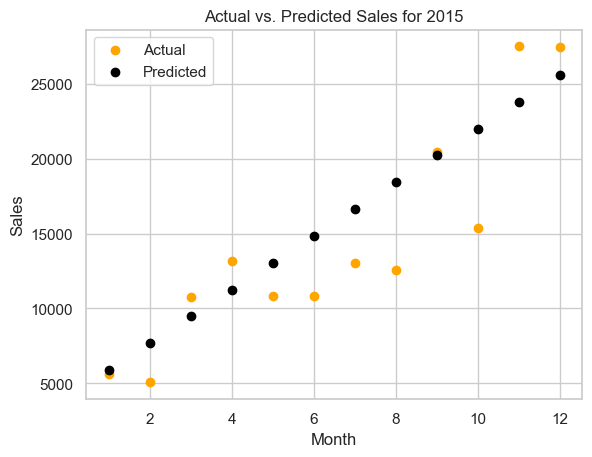

In [125]:
#Graph Sales Data by Year

# Features used during model training
features_used_during_training = ['Year', 'Month']

# Filter the data for the year 2015
sales_df_2015 = sales_df[sales_df['Year'] == 2015]

# Extract features (Year and Month) for the year 2015
X_2015 = sales_df_2015[features_used_during_training]

# Predict the sales for 2015 using the model
y_pred_2015 = model.predict(X_2015)

# Actual sales for 2015 (assuming you have this data)
y_2015 = sales_df_2015['Sales']

# Calculate R2 for actual and predicted sales in 2015
r2_actual_2015 = r2_score(y_2015, y_2015)  # R2 for actual sales in 2015
r2_predicted_2015 = r2_score(y_2015, y_pred_2015)  # R2 for predicted sales in 2015

print("R-squared (R2) for Actual Sales in 2015:", r2_actual_2015)
print("R-squared (R2) for Predicted Sales in 2015:", r2_predicted_2015)

# Create a plot that shows actual sales vs. predicted sales for 2015
plt.scatter(X_2015['Month'], y_2015, color='orange', label='Actual')
plt.scatter(X_2015['Month'], y_pred_2015, color='black', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs. Predicted Sales for 2015')
plt.show()


R-squared (R2) for Actual Sales in 2016: 1.0
R-squared (R2) for Predicted Sales in 2016: 0.6419901622891308


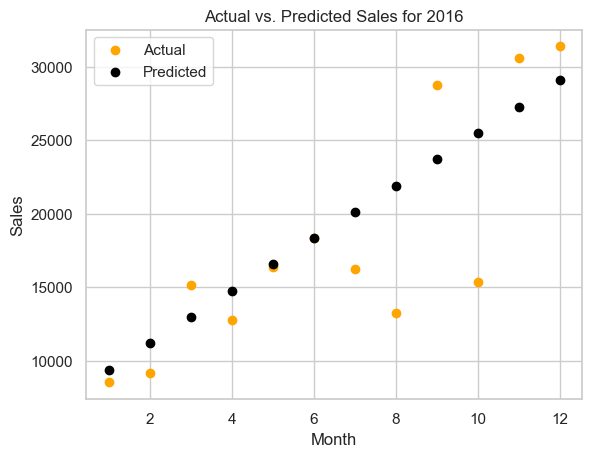

In [126]:
#Graph Sales Data by Year

# Features used during model training
features_used_during_training = ['Year', 'Month']

# Filter the data for the year 2016
sales_df_2016 = sales_df[sales_df['Year'] == 2016]

# Extract features (Year and Month) for the year 2016
X_2016 = sales_df_2016[features_used_during_training]

# Predict the sales for 2016 using the model
y_pred_2016 = model.predict(X_2016)

# Actual sales for 2016 (assuming you have this data)
y_2016 = sales_df_2016['Sales']

# Calculate R2 for actual and predicted sales in 2016
r2_actual_2016 = r2_score(y_2016, y_2016)  # R2 for actual sales in 2016
r2_predicted_2016 = r2_score(y_2016, y_pred_2016)  # R2 for predicted sales in 2016

print("R-squared (R2) for Actual Sales in 2016:", r2_actual_2016)
print("R-squared (R2) for Predicted Sales in 2016:", r2_predicted_2016)

# Create a plot that shows actual sales vs. predicted sales for 2016
plt.scatter(X_2016['Month'], y_2016, color='orange', label='Actual')
plt.scatter(X_2016['Month'], y_pred_2016, color='black', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs. Predicted Sales for 2016')
plt.show()


R-squared (R2) for Actual Sales in 2017: 1.0
R-squared (R2) for Predicted Sales in 2017: 0.6461950278714539


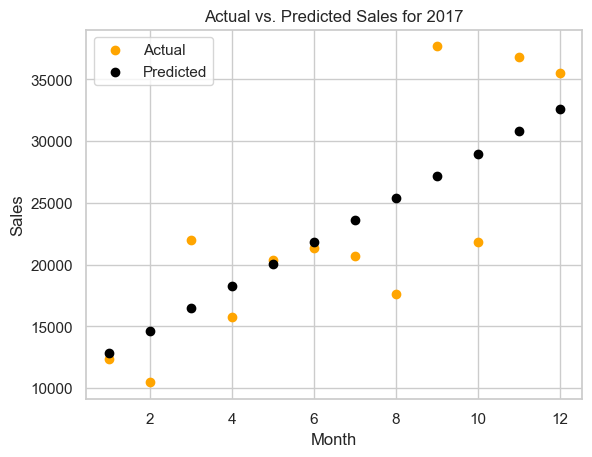

In [127]:
#Graph Sales Data by Year

# Features used during model training
features_used_during_training = ['Year', 'Month']

# Filter the data for the year 2017
sales_df_2017 = sales_df[sales_df['Year'] == 2017]

# Extract features (Year and Month) for the year 2017
X_2017 = sales_df_2017[features_used_during_training]

# Predict the sales for 2017 using the model
y_pred_2017 = model.predict(X_2017)

# Actual sales for 2017 (assuming you have this data)
y_2017 = sales_df_2017['Sales']

# Calculate R2 for actual and predicted sales in 2017
r2_actual_2017 = r2_score(y_2017, y_2017)  # R2 for actual sales in 2017
r2_predicted_2017 = r2_score(y_2017, y_pred_2017)  # R2 for predicted sales in 2017

print("R-squared (R2) for Actual Sales in 2017:", r2_actual_2017)
print("R-squared (R2) for Predicted Sales in 2017:", r2_predicted_2017)

# Create a plot that shows actual sales vs. predicted sales for 2017
plt.scatter(X_2017['Month'], y_2017, color='orange', label='Actual')
plt.scatter(X_2017['Month'], y_pred_2017, color='black', label='Predicted')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Actual vs. Predicted Sales for 2017')
plt.show()



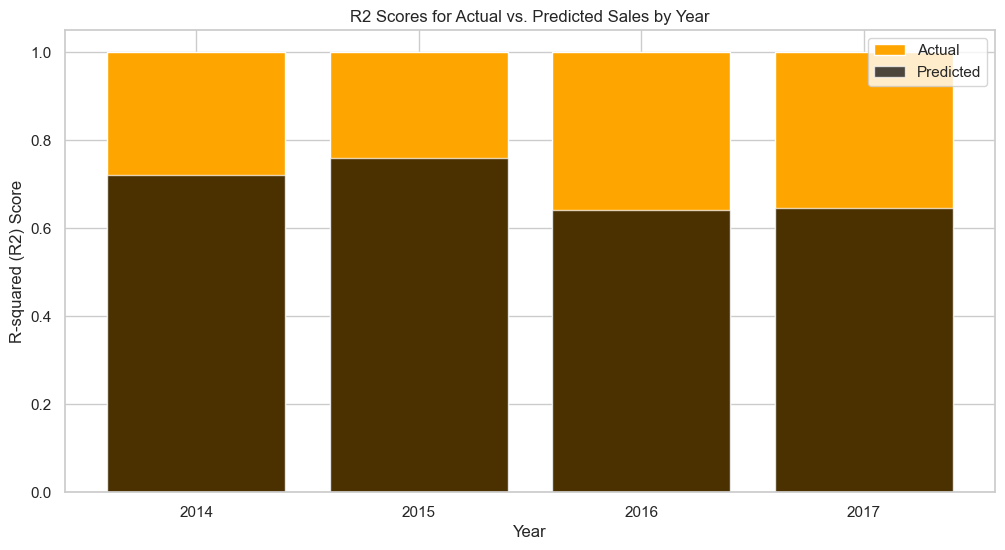

In [128]:
#Graph R2 for all years

# Features used during model training
features_used_during_training = ['Year', 'Month']

# Get a list of unique years in your dataset
unique_years = sales_df['Year'].unique()

# Initialize lists to store R2 scores and labels for each year
r2_actual_scores = []
r2_predicted_scores = []
year_labels = []

# Loop through each year, calculate R2, and create a plot
for year in unique_years:
    # Filter the data for the current year
    sales_data_year = sales_df[sales_df['Year'] == year]

    # Extract features (Year and Month) for the current year
    X_year = sales_data_year[features_used_during_training]

    # Predict the sales for the current year using the model
    y_pred_year = model.predict(X_year)

    # Actual sales for the current year
    y_year = sales_data_year['Sales']

    # Calculate R2 for actual and predicted sales in the current year
    r2_actual_year = r2_score(y_year, y_year)  # R2 for actual sales in the current year
    r2_predicted_year = r2_score(y_year, y_pred_year)  # R2 for predicted sales in the current year

    # Append R2 scores and year labels to the lists
    r2_actual_scores.append(r2_actual_year)
    r2_predicted_scores.append(r2_predicted_year)
    year_labels.append(str(year))

# Plot R2 scores for actual and predicted sales for all years
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(year_labels, r2_actual_scores, label='Actual', color='orange')
plt.bar(year_labels, r2_predicted_scores, label='Predicted', color='black', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('R-squared (R2) Score')
plt.legend()
plt.title('R2 Scores for Actual vs. Predicted Sales by Year')
plt.show()


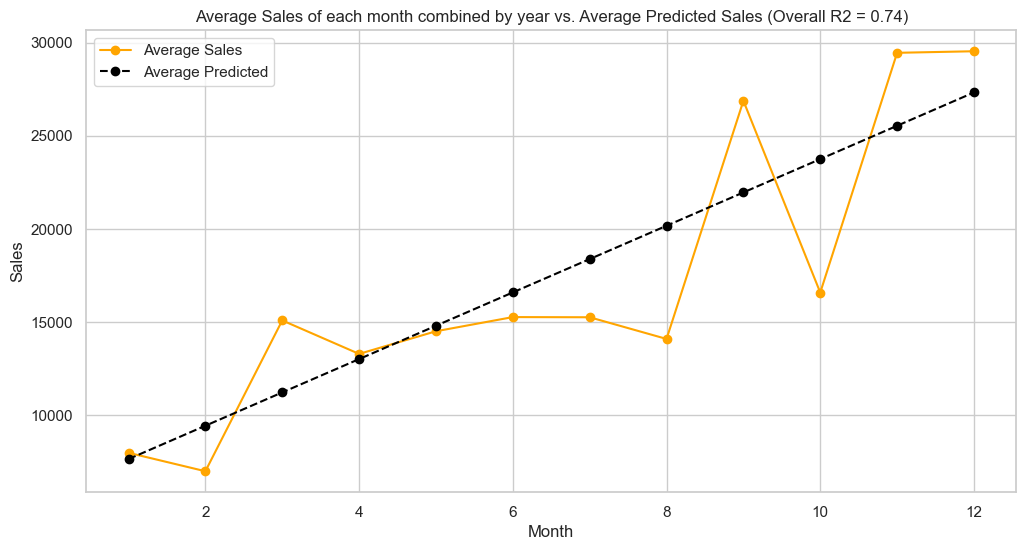

In [132]:
#Graph Sales Data by the average of months with all the years combined
# Features used during model training
features_used_during_training = ['Year', 'Month']

# Get a list of unique years in your dataset
unique_years = sales_df['Year'].unique()

# Initialize lists to store average sales and predicted values for each month
average_sales = []
predicted_sales_combined = []

# Iterate through each month (assuming there are 12 months in your data)
for month in range(1, 13):
    # Filter the data for the current month across all years
    sales_data_month = sales_df[sales_df['Month'] == month]

    # Extract features (Year and Month) for the current month
    X_month = sales_data_month[features_used_during_training]

    # Actual sales for the current month
    y_month = sales_data_month['Sales']

    # Calculate the average sales for the current month
    average_sales_month = y_month.mean()

    # Predict the sales for the current month using the model
    y_pred_month = model.predict(X_month)

    # Calculate the average predicted sales for the current month
    average_predicted_month = y_pred_month.mean()

    # Append average sales and average predicted values to the lists
    average_sales.append(average_sales_month)
    predicted_sales_combined.append(average_predicted_month)

# Calculate the overall R2 score for the combined average sales and predicted values
overall_r2 = r2_score(average_sales, predicted_sales_combined)

# Create a figure for the combined plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the average sales and average predicted values for each month
plt.plot(range(1, 13), average_sales, label='Average Sales', marker='o', linestyle='-', color='orange')
plt.plot(range(1, 13), predicted_sales_combined, label='Average Predicted', marker='o', linestyle='--', color='black')

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title(f'Average Sales of each month combined by year vs. Average Predicted Sales (Overall R2 = {overall_r2:.2f})')

# Show the plot
plt.show()


In [133]:
# Example: Predict sales for January 2024
new_data = pd.DataFrame({'Year': [2024], 'Month': [1]})
predicted_sales = model.predict(new_data)
print("Predicted Sales for January 2024:", predicted_sales[0])

Predicted Sales for January 2024: 37338.13207189087


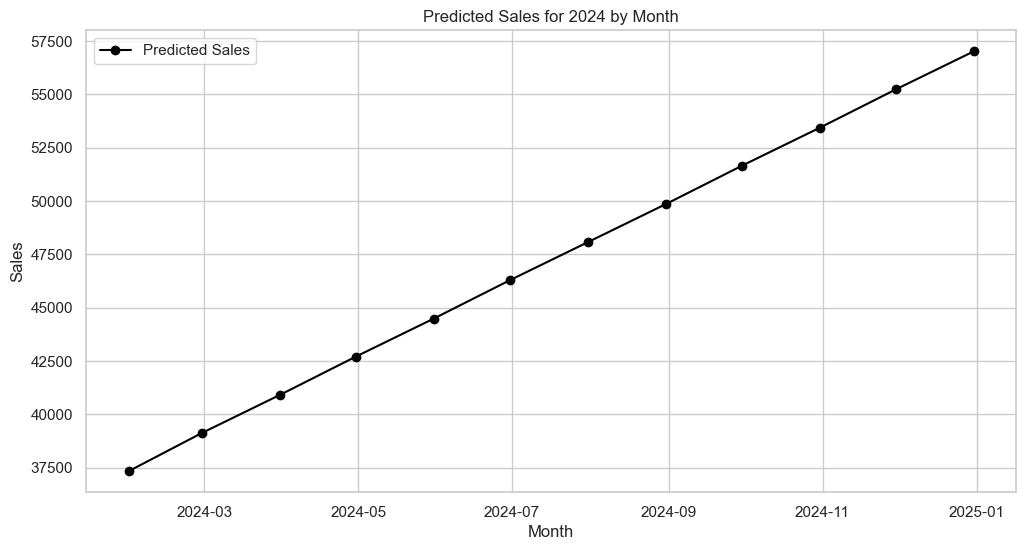

In [134]:
#Predict sales by month for 2024
# Create a DataFrame for the year 2024 with "Year" and "Month" columns
months_2024 = pd.date_range(start='2024-01-01', periods=12, freq='M')
df_2024 = pd.DataFrame({'Year': months_2024.year, 'Month': months_2024.month})

# Use your trained model to predict sales for 2024
y_pred_2024 = model.predict(df_2024)

# Create a plot to visualize the predicted sales for 2024
plt.figure(figsize=(12, 6))
plt.plot(months_2024, y_pred_2024, marker='o', color='black', label='Predicted Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.title('Predicted Sales for 2024 by Month')
plt.show()
